**Brijee Rana** \\
br1e21

should probably write some stuff here

# Libraries + gpu/cpu + google drive setup

In [ ]:
#colab pro perks
#gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Sep 14 18:57:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#access high memory vm
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from contextlib import nullcontext
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import argparse
import time
import os
import csv
import json
from scipy.io.wavfile import write
import warnings
import numpy as np
from scipy.io import wavfile
import wave
#!pip install pydub
import sys
#from pydub import AudioSegment
import matplotlib.pyplot as plt

# Data pre-processing

In [ ]:
#concatenate monophonic and polyphonic audio
"""
infiles = ["/content/drive/MyDrive/Msc Project/Data/Monophone sequence.wav", "/content/drive/MyDrive/Msc Project/Data/Polyphone sequence.wav"]
outfile = "/content/drive/MyDrive/Msc Project/Data/Audiosequence.wav"

data= []
for infile in infiles:
    w = wave.open(infile, 'rb')
    data.append( [w.getparams(), w.readframes(w.getnframes())] )
    w.close()
    
output = wave.open(outfile, 'wb')
output.setparams(data[0][0])
for i in range(len(data)):
    output.writeframes(data[i][1])
output.close()
"""

'\ninfiles = ["/content/drive/MyDrive/Msc Project/Data/Monophone sequence.wav", "/content/drive/MyDrive/Msc Project/Data/Polyphone sequence.wav"]\noutfile = "/content/drive/MyDrive/Msc Project/Data/Audiosequence.wav"\n\ndata= []\nfor infile in infiles:\n    w = wave.open(infile, \'rb\')\n    data.append( [w.getparams(), w.readframes(w.getnframes())] )\n    w.close()\n    \noutput = wave.open(outfile, \'wb\')\noutput.setparams(data[0][0])\nfor i in range(len(data)):\n    output.writeframes(data[i][1])\noutput.close()\n'

In [ ]:
#Amplitude normalization to the raw recordings
"""
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

sound = AudioSegment.from_file("/content/drive/MyDrive/Msc Project/Data/Audiosequence.wav", "wav")
normalized_sound = match_target_amplitude(sound, -20.0)
normalized_sound.export("/content/drive/MyDrive/Msc Project/Data/Audiosequence.wav", format="wav")
"""

'\ndef match_target_amplitude(sound, target_dBFS):\n    change_in_dBFS = target_dBFS - sound.dBFS\n    return sound.apply_gain(change_in_dBFS)\n\nsound = AudioSegment.from_file("/content/drive/MyDrive/Msc Project/Data/Audiosequence.wav", "wav")\nnormalized_sound = match_target_amplitude(sound, -20.0)\nnormalized_sound.export("/content/drive/MyDrive/Msc Project/Data/Audiosequence.wav", format="wav")\n'

In [ ]:
#one of the notes being played
"""
wavfileclean = wave.open("/content/drive/MyDrive/Msc Project/input.wav","r")

# Extract Raw Audio from Wav File
signal1 = wavfileclean.readframes(-1)
signal1 = np.fromstring(signal1, dtype=np.int16)
fs1 = wavfileclean.getframerate()

Time1 = np.linspace(0, len(signal1) / fs1, num=len(signal1))

plt.figure(1)
plt.title("Clean Signal Wave")
plt.plot(Time1, signal1)
plt.show()
"""


'\nwavfileclean = wave.open("/content/drive/MyDrive/Msc Project/input.wav","r")\n\n# Extract Raw Audio from Wav File\nsignal1 = wavfileclean.readframes(-1)\nsignal1 = np.fromstring(signal1, dtype=np.int16)\nfs1 = wavfileclean.getframerate()\n\nTime1 = np.linspace(0, len(signal1) / fs1, num=len(signal1))\n\nplt.figure(1)\nplt.title("Clean Signal Wave")\nplt.plot(Time1, signal1)\nplt.show()\n'

In [ ]:
#Spectograms
"""
sample_rate = 16000  #44.1khz audio sample rate

wavfileclean = wave.open("/content/drive/MyDrive/Msc Project/input.wav","r")

sig1 = np.frombuffer(wavfileclean.readframes(sample_rate), dtype=np.int16)

plt.figure(1)
plt.title("Clean Signal Wave")
plt.specgram(sig1, NFFT=1024, Fs=sample_rate, noverlap=900)
plt.show()
"""


'\nsample_rate = 16000  #44.1khz audio sample rate\n\nwavfileclean = wave.open("/content/drive/MyDrive/Msc Project/input.wav","r")\n\nsig1 = np.frombuffer(wavfileclean.readframes(sample_rate), dtype=np.int16)\n\nplt.figure(1)\nplt.title("Clean Signal Wave")\nplt.specgram(sig1, NFFT=1024, Fs=sample_rate, noverlap=900)\nplt.show()\n'

In [ ]:
#Playing audio files
#import IPython
#clean
#IPython.display.Audio("/content/drive/MyDrive/Msc Project/input.wav")

In [ ]:
##normalise properly the audio files properly!
# maps them to an amplitude between -1 and 1
"""

def save_wav(name, data):
    wavfile.write(name, 44100, data)

def normalize(data):
    data_max = max(data)
    data_min = min(data)
    data_norm = max(data_max,abs(data_min))
    return data / data_norm

in_rate, in_data = wavfile.read("/content/drive/MyDrive/Msc Project/Data/val/chorus-input.wav")

# If Desired Normalize the data
norm_data = normalize(in_data)

save_wav("/content/drive/MyDrive/Msc Project/Data/val/chorust-input.wav", norm_data)
"""
  

'\n\ndef save_wav(name, data):\n    wavfile.write(name, 44100, data)\n\ndef normalize(data):\n    data_max = max(data)\n    data_min = min(data)\n    data_norm = max(data_max,abs(data_min))\n    return data / data_norm\n\nin_rate, in_data = wavfile.read("/content/drive/MyDrive/Msc Project/Data/val/chorus-input.wav")\n\n# If Desired Normalize the data\nnorm_data = normalize(in_data)\n\nsave_wav("/content/drive/MyDrive/Msc Project/Data/val/chorust-input.wav", norm_data)\n'

# RNN Model

LSTM model from:
Real-Time Guitar Amplifier Emulation with Deep Learning.

https://www.dafx.de/paper-archive/2019/DAFx2019_paper_43.pdf

The neural network architecture: LSTM layer followed by a Dense layer. An audio sample is given and a sample is predicted. A skip connection is performed.
Model is found here as "SimpleRNN"

https://github.com/Alec-Wright/CoreAudioML/tree/main


I used the network architecture, some of the functions to train the model and save those models in the json files. All of data and data pre-processing, plotting, experimentations and modification are of my own.


# CoreAudioML 
Functions and classes that are used to train the neural network model.

In [ ]:
#misc funcs

# Function that checks if a directory exists, and creates it if it doesn't, if dir_name is a list of strings, it will
# create a search path, i.e dir_name = ['directory', 'subdir'] will search for directory 'directory/subdir'
def dir_check(dir_name):
    dir_name = [dir_name] if not type(dir_name) == list else dir_name
    dir_path = os.path.join(*dir_name)
    if os.path.isdir(dir_path):
        pass
    else:
        os.mkdir(dir_path)


# Function that takes a file_name and optionally a path to the directory the file is expected to be, returns true if
# the file is found in the stated directory (or the current directory is dir_name = '') or False is dir/file isn't found
def file_check(file_name, dir_name=''):
    assert type(file_name) == str
    dir_name = [dir_name] if ((type(dir_name) != list) and (dir_name)) else dir_name
    full_path = os.path.join(*dir_name, file_name)
    return os.path.isfile(full_path)


# Function that saves 'data' to a json file. Constructs a file path is dir_name is provided.
def json_save(data, file_name, dir_name=''):
    dir_name = [dir_name] if ((type(dir_name) != list) and (dir_name)) else dir_name
    assert type(file_name) == str
    file_name = file_name + '.json' if not file_name.endswith('.json') else file_name
    full_path = os.path.join(*dir_name, file_name)
    with open(full_path, 'w') as fp:
        json.dump(data, fp)


def json_load(file_name, dir_name=''):
    dir_name = [dir_name] if ((type(dir_name) != list) and (dir_name)) else dir_name
    file_name = file_name + '.json' if not file_name.endswith('.json') else file_name
    full_path = os.path.join(*dir_name, file_name)
    with open(full_path) as fp:
        return json.load(fp)


def load_config(args):
    # Load the configs and write them onto the args dictionary, this will add new args and/or overwrite old ones
    configs = json_load(args.load_config, args.config_location)
    for parameters in configs:
        args.__setattr__(parameters, configs[parameters])
    return args

In [ ]:
#networks


def wrapperkwargs(func, kwargs):
    return func(**kwargs)

def wrapperargs(func, args):
    return func(*args)

# A simple RNN class that consists of a single recurrent unit of type LSTM, GRU or Elman, followed by a fully connected
# layer

class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, output_size=1, unit_type="LSTM", hidden_size=32, skip=1, bias_fl=True,
                 num_layers=1):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        # Create dictionary of possible block types
        self.rec = wrapperargs(getattr(nn, unit_type), [input_size, hidden_size, num_layers])  #This sets the LSTM layer
        self.lin = nn.Linear(hidden_size, output_size, bias=bias_fl)
        self.bias_fl = bias_fl
        self.skip = skip
        self.save_state = True
        self.hidden = None

    def forward(self, x):
        if self.skip:
            # save the residual for the skip connection
            res = x[:, :, 0:self.skip]
            x, self.hidden = self.rec(x, self.hidden)
            return self.lin(x) + res
        else:
            x, self.hidden = self.rec(x, self.hidden)
            return self.lin(x)

    # detach hidden state, this resets gradient tracking on the hidden state
    def detach_hidden(self):
        if self.hidden.__class__ == tuple:
            self.hidden = tuple([h.clone().detach() for h in self.hidden])
        else:
            self.hidden = self.hidden.clone().detach()

    # changes the hidden state to None, causing pytorch to create an all-zero hidden state when the rec unit is called
    def reset_hidden(self):
        self.hidden = None

    # This functions saves the model and all its paraemters to a json file, so it can be loaded by a JUCE plugin
    def save_model(self, file_name, direc=''):
        if direc:
            dir_check(direc)
        model_data = {'model_data': {'model': 'SimpleRNN', 'input_size': self.rec.input_size, 'skip': self.skip,
                                     'output_size': self.lin.out_features, 'unit_type': self.rec._get_name(),
                                     'num_layers': self.rec.num_layers, 'hidden_size': self.rec.hidden_size,
                                     'bias_fl': self.bias_fl}}

        if self.save_state:
            model_state = self.state_dict()
            for each in model_state:
                model_state[each] = model_state[each].tolist()
            model_data['state_dict'] = model_state

        json_save(model_data, file_name, direc)

    # train_epoch runs one epoch of training
    def train_epoch(self, input_data, target_data, loss_fcn, optim, bs, init_len=200, up_fr=1000):
        # shuffle the segments at the start of the epoch
        shuffle = torch.randperm(input_data.shape[1])

        # Iterate over the batches
        ep_loss = 0
        for batch_i in range(math.ceil(shuffle.shape[0] / bs)):
            # Load batch of shuffled segments
            input_batch = input_data[:, shuffle[batch_i * bs:(batch_i + 1) * bs], :]
            target_batch = target_data[:, shuffle[batch_i * bs:(batch_i + 1) * bs], :]

            # Initialise network hidden state by processing some samples then zero the gradient buffers
            self(input_batch[0:init_len, :, :])
            self.zero_grad()

            # Choose the starting index for processing the rest of the batch sequence, in chunks of args.up_fr
            start_i = init_len
            batch_loss = 0
            # Iterate over the remaining samples in the mini batch
            for k in range(math.ceil((input_batch.shape[0] - init_len) / up_fr)):
                # Process input batch with neural network
                output = self(input_batch[start_i:start_i + up_fr, :, :])

                # Calculate loss and update network parameters
                loss = loss_fcn(output, target_batch[start_i:start_i + up_fr, :, :])
                loss.backward()
                optim.step()

                # Set the network hidden state, to detach it from the computation graph
                self.detach_hidden()
                self.zero_grad()

                # Update the start index for the next iteration and add the loss to the batch_loss total
                start_i += up_fr
                batch_loss += loss

            # Add the average batch loss to the epoch loss and reset the hidden states to zeros
            ep_loss += batch_loss / (k + 1)
            self.reset_hidden()
        return ep_loss / (batch_i + 1)

    # only proc processes a the input data and calculates the loss, optionally grad can be tracked or not
    def process_data(self, input_data, target_data, loss_fcn, chunk, grad=False):
        with (torch.no_grad() if not grad else nullcontext()):
            output = torch.empty_like(target_data)
            for l in range(int(output.size()[0] / chunk)):
                output[l * chunk:(l + 1) * chunk] = self(input_data[l * chunk:(l + 1) * chunk])
                self.detach_hidden()
            # If the data set doesn't divide evenly into the chunk length, process the remainder
            if not (output.size()[0] / chunk).is_integer():
                output[(l + 1) * chunk:-1] = self(input_data[(l + 1) * chunk:-1])
            self.reset_hidden()
            loss = loss_fcn(output, target_data)
        return output, loss


""" 
Recurrent Neural Network class, blocks is a list of layers, each layer is described by a dictionary, layers can also
be added after initialisation via the 'add_layer' function
params is a dict that holds 'meta parameters' for the whole network
skip inserts a skip connection from the input to the output, the value of skip determines how many of the input
channels to add to the output (if skip = 2, for example, the output must have at least two channels)
e.g blocks = {'block_type': 'RNN', 'input_size': 1, 'output_size': 1, 'hidden_size': 16}
This allows you to add an arbitrary number of RNN blocks. The SimpleRNN is easier to use but only includes one reccurent
unit followed by a fully connect layer.
"""
class RecNet(nn.Module):
    def __init__(self, blocks=None, skip=0):
        super(RecNet, self).__init__()
        if type(blocks) == dict:
            blocks = [blocks]
        # Create container for layers
        self.layers = nn.Sequential()
        # Create dictionary of possible block types
        self.block_types = {}
        self.block_types.update(dict.fromkeys(['RNN', 'LSTM', 'GRU'], BasicRNNBlock))
        self.skip = skip
        self.save_state = False
        self.input_size = None
        self.training_info = {'current_epoch': 0, 'training_losses': [], 'validation_losses': [],
                              'train_epoch_av': 0.0, 'val_epoch_av': 0.0, 'total_time': 0.0, 'best_val_loss': 1e12}
        # If layers were specified, create layers
        try:
            for each in blocks:
                self.add_layer(each)
        except TypeError:
            print('no blocks provided, add blocks to the network via the add_layer method')

    # Define forward pass
    def forward(self, x):
        if not self.skip:
            return self.layers(x)
        else:
            res = x[:, :, 0:self.skip]
            return self.layers(x) + res

    # Set hidden state to specified values, resets gradient tracking
    def detach_hidden(self):
        for each in self.layers:
            each.detach_hidden()

    def reset_hidden(self):
        for each in self.layers:
            each.reset_hidden()
            
    # Add layer to the network, params is a dictionary contains the layer keyword arguments
    def add_layer(self, params):
        # If this is the first layer, define the network input size
        if self.input_size:
            pass
        else:
            self.input_size = params['input_size']

        self.layers.add_module('block_'+str(1 + len(list(self.layers.children()))),
                               self.block_types[params['block_type']](params))
        self.output_size = params['output_size']

    def save_model(self, file_name, direc=''):
        if direc:
            dir_check(direc)

        model_data = {'model_data': {'model': 'RecNet', 'skip': 0}, 'blocks': {}}
        for i, each in enumerate(self.layers):
            model_data['blocks'][str(i)] = each.params

        if self.training_info:
            model_data['training_info'] = self.training_info

        if self.save_state:
            model_state = self.state_dict()
            for each in model_state:
                model_state[each] = model_state[each].tolist()
            model_data['state_dict'] = model_state

        json_save(model_data, file_name, direc)


class BasicRNNBlock(nn.Module):
    def __init__(self, params):
        super(BasicRNNBlock, self).__init__()
        assert type(params['input_size']) == int, "an input_size of int type must be provided in 'params'"
        assert type(params['output_size']) == int, "an output_size of int type must be provided in 'params'"
        assert type(params['hidden_size']) == int, "an hidden_size of int type must be provided in 'params'"

        rec_params = {i: params[i] for i in params if i in ['input_size', 'hidden_size', 'num_layers']}
        self.params = params
        # This just calls nn.LSTM() if 'block_type' is LSTM, nn.GRU() if GRU, etc
        self.rec = wrapperkwargs(getattr(nn, params['block_type']), rec_params)
        self.lin_bias = params['lin_bias'] if 'lin_bias' in params else False
        self.lin = nn.Linear(params['hidden_size'], params['output_size'], self.lin_bias)
        self.hidden = None
        # If the 'skip' param was provided, set to provided value (1 for skip connection, 0 otherwise), is 1 by default
        if 'skip' in params:
            self.skip = params['skip']
        else:
            self.skip = 1

    def forward(self, x):
        if self.skip:
            # save the residual for the skip connection
            res = x[:, :, 0:self.skip]
            x, self.hidden = self.rec(x, self.hidden)
            return self.lin(x) + res
        else:
            x, self.hidden = self.rec(x, self.hidden)
            return self.lin(x)

    # detach hidden state, this resets gradient tracking on the hidden state
    def detach_hidden(self):
        if self.hidden.__class__ == tuple:
            self.hidden = tuple([h.clone().detach() for h in self.hidden])
        else:
            self.hidden = self.hidden.clone().detach()

    def reset_hidden(self):
        self.hidden = None


def load_model(model_data):
    model_types = {'RecNet': RecNet, 'SimpleRNN': SimpleRNN}

    model_meta = model_data.pop('model_data')

    if model_meta['model'] == 'SimpleRNN':
        network = wrapperkwargs(model_types[model_meta.pop('model')], model_meta)
        if 'state_dict' in model_data:
            state_dict = network.state_dict()
            for each in model_data['state_dict']:
                state_dict[each] = torch.tensor(model_data['state_dict'][each])
            network.load_state_dict(state_dict)

    elif model_meta['model'] == 'RecNet':
        model_meta['blocks'] = []
        network = wrapperkwargs(model_types[model_meta.pop('model')], model_meta)
        for i in range(len(model_data['blocks'])):
            network.add_layer(model_data['blocks'][str(i)])

        # Get the state dict from the newly created model and load the saved states, if states were saved
        if 'state_dict' in model_data:
            state_dict = network.state_dict()
            for each in model_data['state_dict']:
                state_dict[each] = torch.tensor(model_data['state_dict'][each])
            network.load_state_dict(state_dict)

        if 'training_info' in model_data.keys():
            network.training_info = model_data['training_info']

    return network

In [ ]:
#dataset


# Function converting np read audio to range of -1 to +1
def audio_converter(audio):
    if audio.dtype == 'int16':
        return audio.astype(np.float32, order='C') / 32768.0
    else:
        print('unimplemented audio data type conversion...')
        return audio.astype(np.float32)


# Splits audio, each split marker determines the fraction of the total audio in that split, i.e [0.75, 0.25] will put
# 75% in the first split and 25% in the second
def audio_splitter(audio, split_markers):
    assert sum(split_markers) <= 1.0
    if sum(split_markers) < 0.999:
        warnings.warn("sum of split markers is less than 1, so not all audio will be included in dataset")
    start = 0
    slices = []
    # convert split markers to samples
    split_bounds = [int(x * audio.shape[0]) for x in split_markers]
    for n in split_bounds:
        end = start + n
        slices.append(audio[start:end])
        start = end
    return slices


# converts numpy audio into frames, and creates a torch tensor from them, frame_len = 0 just converts to a torch tensor
def framify(audio, frame_len):
    # If audio is mono, add a dummy dimension, so the same operations can be applied to mono/multichannel audio
    audio = np.expand_dims(audio, 1) if len(audio.shape) == 1 else audio
    # Calculate the number of segments the training data will be split into in frame_len is not 0
    seg_num = math.floor(audio.shape[0] / frame_len) if frame_len else 1
    # If no frame_len is provided, set frame_len to be equal to length of the input audio
    frame_len = audio.shape[0] if not frame_len else frame_len
    # Find the number of channels
    channels = audio.shape[1]
    # Initialise tensor matrices
    dataset = torch.empty((frame_len, seg_num, channels))
    # Load the audio for the training set
    for i in range(seg_num):
        dataset[:, i, :] = torch.from_numpy(audio[i * frame_len:(i + 1) * frame_len, :])
    return dataset


"""This is the main DataSet class, it can hold any number of subsets, which could be, e.g, the training/test/val sets.
The subsets are created by the create_subset method and stored in the DataSet.subsets dictionary. 
datadir: is the default location where the DataSet instance will look when told to load an audio file
extensions: is the default ends of the paired data files, when using paired data, so by default when loading the file
 'wicked_guitar', the load_file method with look for 'wicked_guitar-input.wav' and 'wicked_guitar-target.wav'
 to disable this behaviour, enter extensions = '', or None, or anything that evaluates to false in python """

filename = 'chorus'

class DataSet:
    def __init__(self, data_dir='../Dataset/', extensions=('input', 'target')):
        self.extensions = extensions if extensions else ['']
        self.subsets = {}
        assert type(data_dir) == str, "data_dir should be string,not %r" % {type(data_dir)}
        self.data_dir = data_dir

    # add a subset called 'name', desired 'frame_len' is given in seconds, or 0 for just one long frame
    def create_subset(self, name, frame_len=0):
        assert type(name) == str, "data subset name must be a string, not %r" %{type(name)}
        assert not (name in self.subsets), "subset %r already exists" %name
        self.subsets[name] = SubSet(frame_len)

    # load a file of 'filename' into existing subset/s 'set_names', split fractionally as specified by 'splits',
    # if 'cond_val' is provided the conditioning value will be saved along with the frames of the loaded data
    def load_file(self, filename, set_names='train', splits=None, cond_val=None):
        # Assertions and checks
        if type(set_names) == str:
            set_names = [set_names]
        assert len(set_names) == 1 or len(set_names) == len(splits), "number of subset names must equal number of " \
                                                                     "split markers"
        assert [self.subsets.get(each) for each in set_names], "set_names contains subsets that don't exist yet"

        # Load each of the 'extensions'
        for i, ext in enumerate(self.extensions):
            try:
                file_loc = os.path.join(self.data_dir, filename + '-' + ext)
                file_loc = file_loc + '.wav' if not file_loc.endswith('.wav') else file_loc
                np_data = wavfile.read(file_loc)
            except FileNotFoundError:
                file_loc = os.path.join(self.data_dir, filename + ext)
                file_loc = file_loc + '.wav' if not file_loc.endswith('.wav') else file_loc
                np_data = wavfile.read(file_loc)
            except FileNotFoundError:
                print(["File Not Found At: " + self.data_dir + filename])
                return
            #print("np_data", np_data[1])  # KAB DEBUG ######################################
            #print("np_data dtype", np_data[1].dtype)  # KAB DEBUG ######################################
            raw_audio = audio_converter(np_data[1])
            #raw_audio = np_data[1]  # KAB DEBUG ######################################
            #print("raw_audio", raw_audio)  # KAB DEBUG ######################################
            # Split the audio if the set_names were provided
            if len(set_names) > 1:
                raw_audio = audio_splitter(raw_audio, splits)
                for n, sets in enumerate(set_names):
                    self.subsets[set_names[n]].add_data(np_data[0], raw_audio[n], ext, cond_val)
            elif len(set_names) == 1:
                self.subsets[set_names[0]].add_data(np_data[0], raw_audio, ext, cond_val)


# The SubSet class holds a subset of data,
# frame_len sets the length of audio per frame (in s), if set to 0 a single frame is used instead
class SubSet:
    def __init__(self, frame_len):
        self.data = {}
        self.cond_data = {}
        self.frame_len = frame_len
        self.conditioning = None
        self.fs = None

    # Add 'audio' data, in the data dictionary at the key 'ext', if cond_val is provided save the cond_val of each frame
    def add_data(self, fs, audio, ext, cond_val):
        if not self.fs:
            self.fs = fs
        assert self.fs == fs, "data with different sample rate provided to subset"
        # if no 'ext' is provided, all the subsets data will be stored at the 'data' key of the 'data' dict
        ext = 'data' if not ext else ext
        # Frame the data and optionally create a tensor of the conditioning values of each frame
        framed_data = framify(audio, self.frame_len)
        cond_data = cond_val * torch.ones(framed_data.shape[1]) if isinstance(cond_val, (float, int)) else None

        try:
            # Convert data from tuple to list and concatenate new data onto the data tensor
            data = list(self.data[ext])
            self.data[ext] = (torch.cat((data[0], framed_data), 1),)
            # If cond_val is provided add it to the cond_val tensor, note all frames or no frames must have cond vals
            if isinstance(cond_val, (float, int)):
                assert torch.is_tensor(self.cond_data[ext][0]), 'cond val provided, but previous data has no cond val'
                c_data = list(self.cond_data[ext])
                self.cond_data[ext] = (torch.cat((c_data[0], cond_data), 0),)
        # If this is the first data to be loaded into the subset, create the data and cond_data tuples
        except KeyError:
            self.data[ext] = (framed_data,)
            self.cond_data[ext] = (cond_data,)

In [ ]:
#training

# ESR loss calculates the Error-to-signal between the output/target
class ESRLoss(nn.Module):
    def __init__(self):
        super(ESRLoss, self).__init__()
        self.epsilon = 0.00001

    def forward(self, output, target):
        loss = torch.add(target, -output)
        loss = torch.pow(loss, 2)
        loss = torch.mean(loss)
        energy = torch.mean(torch.pow(target, 2)) + self.epsilon
        loss = torch.div(loss, energy)
        return loss


class DCLoss(nn.Module):
    def __init__(self):
        super(DCLoss, self).__init__()
        self.epsilon = 0.00001

    def forward(self, output, target):
        loss = torch.pow(torch.add(torch.mean(target, 0), -torch.mean(output, 0)), 2)
        loss = torch.mean(loss)
        energy = torch.mean(torch.pow(target, 2)) + self.epsilon
        loss = torch.div(loss, energy)
        return loss


# PreEmph is a class that applies an FIR pre-emphasis filter to the signal, the filter coefficients are in the
# filter_cfs argument, and lp is a flag that also applies a low pass filter
# Only supported for single-channel!
class PreEmph(nn.Module):
    def __init__(self, filter_cfs, low_pass=0):
        super(PreEmph, self).__init__()
        self.epsilon = 0.00001
        self.zPad = len(filter_cfs) - 1

        self.conv_filter = nn.Conv1d(1, 1, 2, bias=False)
        self.conv_filter.weight.data = torch.tensor([[filter_cfs]], requires_grad=False)

        self.low_pass = low_pass
        if self.low_pass:
            self.lp_filter = nn.Conv1d(1, 1, 2, bias=False)
            self.lp_filter.weight.data = torch.tensor([[[0.85, 1]]], requires_grad=False)

    def forward(self, output, target):
        # zero pad the input/target so the filtered signal is the same length
        output = torch.cat((torch.zeros(self.zPad, output.shape[1], 1), output))
        target = torch.cat((torch.zeros(self.zPad, target.shape[1], 1), target))
        # Apply pre-emph filter, permute because the dimension order is different for RNNs and Convs in pytorch...
        output = self.conv_filter(output.permute(1, 2, 0))
        target = self.conv_filter(target.permute(1, 2, 0))

        if self.low_pass:
            output = self.lp_filter(output)
            target = self.lp_filter(target)

        return output.permute(2, 0, 1), target.permute(2, 0, 1)

class LossWrapper(nn.Module):
    def __init__(self, losses, pre_filt=None):
        super(LossWrapper, self).__init__()
        loss_dict = {'ESR': ESRLoss(), 'DC': DCLoss()}
        if pre_filt:
            pre_filt = PreEmph(pre_filt)
            loss_dict['ESRPre'] = lambda output, target: loss_dict['ESR'].forward(*pre_filt(output, target))
        loss_functions = [[loss_dict[key], value] for key, value in losses.items()]

        self.loss_functions = tuple([items[0] for items in loss_functions])
        try:
            self.loss_factors = tuple(torch.Tensor([items[1] for items in loss_functions]))
        except IndexError:
            self.loss_factors = torch.ones(len(self.loss_functions))

    def forward(self, output, target):
        loss = 0
        for i, losses in enumerate(self.loss_functions):
            loss += torch.mul(losses(output, target), self.loss_factors[i])
        return loss


class TrainTrack(dict):
    def __init__(self):
        self.update({'current_epoch': 0, 'training_losses': [], 'validation_losses': [], 'train_av_time': 0.0,
                     'val_av_time': 0.0, 'total_time': 0.0, 'best_val_loss': 1e12, 'test_loss': 0})

    def restore_data(self, training_info):
        self.update(training_info)

    def train_epoch_update(self, loss, ep_st_time, ep_end_time, init_time, current_ep):
        if self['train_av_time']:
            self['train_av_time'] = (self['train_av_time'] + ep_end_time - ep_st_time) / 2
        else:
            self['train_av_time'] = ep_end_time - ep_st_time
        self['training_losses'].append(loss)
        self['current_epoch'] = current_ep
        self['total_time'] += ((init_time + ep_end_time - ep_st_time)/3600)

    def val_epoch_update(self, loss, ep_st_time, ep_end_time):
        if self['val_av_time']:
            self['val_av_time'] = (self['val_av_time'] + ep_end_time - ep_st_time) / 2
        else:
            self['val_av_time'] = ep_end_time - ep_st_time
        self['validation_losses'].append(loss)
        if loss < self['best_val_loss']:
            self['best_val_loss'] = loss


# Network training

Training the network architecture

In [ ]:
prsr = argparse.ArgumentParser(
    description='''This script implements training for neural network amplifier/distortion effects modelling. This is
    intended to recreate the training of models of the ht1 amplifier and big muff distortion pedal, but can easily be 
    adapted to use any dataset''')

# arguments for the training/test data locations and file names and config loading
prsr.add_argument('--device', '-p', default='chorus', help='This label describes what device is being modelled')
prsr.add_argument('--data_location', '-dl', default='/content/drive/MyDrive/Msc Project/Data/', help='Location of the "Data" directory')
prsr.add_argument('--file_name', '-fn', default='chorus',
                  help='The filename of the wav file to be loaded as the input/target data, the script looks for files'
                       'with the filename and the extensions -input.wav and -target.wav ')
prsr.add_argument('--load_config', '-l',
                  help="File path, to a JSON config file, arguments listed in the config file will replace the defaults"
                  , default='RNN3')
prsr.add_argument('--config_location', '-cl', default='/content/drive/MyDrive/Msc Project/Configs', help='Location of the "Configs" directory')
prsr.add_argument('--save_location', '-sloc', default='/content/drive/MyDrive/Msc Project/Results', help='Directory where trained models will be saved')
prsr.add_argument('--load_model', '-lm', default=True, help='load a pretrained model if it is found')

# pre-processing of the training/val/test data
prsr.add_argument('--segment_length', '-slen', type=int, default=22050, help='Training audio segment length in samples')

# number of epochs and validation
prsr.add_argument('--epochs', '-eps', type=int, default=2000, help='Max number of training epochs to run')
prsr.add_argument('--validation_f', '-vfr', type=int, default=2, help='Validation Frequency (in epochs)')
# TO DO
prsr.add_argument('--validation_p', '-vp', type=int, default=25,
                  help='How many validations without improvement before stopping training, None for no early stopping')

# settings for the training epoch
prsr.add_argument('--batch_size', '-bs', type=int, default=50, help='Training mini-batch size')
prsr.add_argument('--iter_num', '-it', type=int, default=None,
                  help='Overrides --batch_size and instead sets the batch_size so that a total of --iter_num batches'
                       'are processed in each epoch')
prsr.add_argument('--learn_rate', '-lr', type=float, default=0.005, help='Initial learning rate')
prsr.add_argument('--init_len', '-il', type=int, default=200,
                  help='Number of sequence samples to process before starting weight updates')
prsr.add_argument('--up_fr', '-uf', type=int, default=1000,
                  help='For recurrent models, number of samples to run in between updating network weights, i.e the '
                       'default argument updates every 1000 samples')
prsr.add_argument('--cuda', '-cu', default=1, help='Use GPU if available')

# loss function/s
prsr.add_argument('--loss_fcns', '-lf', default={'ESRPre': 0.75, 'DC': 0.25},
                  help='Which loss functions, ESR, ESRPre, DC. Argument is a dictionary with each key representing a'
                       'loss function name and the corresponding value being the multiplication factor applied to that'
                       'loss function, used to control the contribution of each loss function to the overall loss ')
prsr.add_argument('--pre_filt',   '-pf',   default='high_pass',
                    help='FIR filter coefficients for pre-emphasis filter, can also read in a csv file')

# the validation and test sets are divided into shorter chunks before processing to reduce the amount of GPU memory used
# you can probably ignore this unless during training you get a 'cuda out of memory' error
prsr.add_argument('--val_chunk', '-vs', type=int, default=100000, help='Number of sequence samples to process'
                                                                               'in each chunk of validation ')
prsr.add_argument('--test_chunk', '-tc', type=int, default=100000, help='Number of sequence samples to process'
                                                                               'in each chunk of validation ')

# arguments for the network structure
prsr.add_argument('--model', '-m', default='SimpleRNN', type=str, help='model architecture')
prsr.add_argument('--input_size', '-is', default=1, type=int, help='1 for mono input data, 2 for stereo, etc ')
prsr.add_argument('--output_size', '-os', default=1, type=int, help='1 for mono output data, 2 for stereo, etc ')
prsr.add_argument('--num_blocks', '-nb', default=1, type=int, help='Number of recurrent blocks')
prsr.add_argument('--hidden_size', '-hs', default=16, type=int, help='Recurrent unit hidden state size')
prsr.add_argument('--unit_type', '-ut', default='LSTM', help='LSTM or GRU or RNN')
prsr.add_argument('--skip_con', '-sc', default=1, help='is there a skip connection for the input to the output')

args = prsr.parse_args()
#args = prsr.parse_args(args=[])

# This function takes a directory as argument, looks for an existing model file called 'model.json' and loads a network
# from it, after checking the network in 'model.json' matches the architecture described in args. If no model file is
# found, it creates a network according to the specification in args.

##CHANGE 'model.json to other things u creature for other architectures##

def init_model(save_path, args):
    # Search for an existing model in the save directory
    if file_check('model.json', save_path) and args.load_model:
        print('existing model file found, loading network')
        model_data = json_load('model', save_path)
        # assertions to check that the model.json file is for the right neural network architecture
        try:
            assert model_data['model_data']['unit_type'] == args.unit_type
            assert model_data['model_data']['input_size'] == args.input_size
            assert model_data['model_data']['hidden_size'] == args.hidden_size
            assert model_data['model_data']['output_size'] == args.output_size
        except AssertionError:
            print("model file found with network structure not matching config file structure")
        network = load_model(model_data)
    # If no existing model is found, create a new one
    else:
        print('no saved model found, creating new network')
        network = SimpleRNN(input_size=args.input_size, unit_type=args.unit_type, hidden_size=args.hidden_size,
                                     output_size=args.output_size, skip=args.skip_con)
        network.save_state = False
        network.save_model('model', save_path)
    return network

#its in results ht1-RNN3?


In [ ]:
#Change the argparse 
args.device = 'fuzz'
args.data_location = '/content/drive/MyDrive/Msc Project/Data/'
args.file_name = 'fuzz'
#Load from the .json in configs, overwrites these argparse varible changes
###
args.load_config = 'RNN1'
####
args.config_location = '/content/drive/MyDrive/Msc Project/Configs/'
args.save_location = '/content/drive/MyDrive/Msc Project/Results/'
args.epochs = 150
args.batch_size
args.iter_num
args.learn_rate

#network structure
args.model = 'SimpleRNN'
args.num_blocks = 1
args.hidden_size = 16
args.unit_type = 'LSTM'
args.skip_con = 1

In [ ]:
#somehow different args is used than above?

if __name__ == "__main__":
    """The main method creates the recurrent network, trains it and carries out validation/testing """
    start_time = time.time()

    # If a load_config argument was provided, construct the file path to the config file
    if args.load_config:
        # Load the configs and write them onto the args dictionary, this will add new args and/or overwrite old ones
        configs = json_load(args.load_config, args.config_location)
        for parameters in configs:
            args.__setattr__(parameters, configs[parameters])

    if args.model == 'SimpleRNN':
        model_name = args.model + args.device + '_' + args.unit_type + '_hs' + str(args.hidden_size) + '_pre_' + args.pre_filt
    if args.pre_filt == 'A-Weighting':
        with open('Configs/' + 'b_Awght_mk2.csv') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            args.pre_filt = list(reader)
            args.pre_filt = args.pre_filt[0]
            for item in range(len(args.pre_filt)):
                args.pre_filt[item] = float(args.pre_filt[item])
    elif args.pre_filt == 'high_pass':
        args.pre_filt = [-0.85, 1]
    elif args.pre_filt == 'None':
        args.pre_filt = None

    # Generate name of directory where results will be saved
    save_path = os.path.join(args.save_location, args.device + '-' + args.load_config)

    # Check if an existing saved model exists, and load it, otherwise creates a new model
    network = init_model(save_path, args)

    # Check if a cuda device is available
    if not torch.cuda.is_available() or args.cuda == 0:
        print('cuda device not available/not selected')
        cuda = 0
    else:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
        torch.cuda.set_device(0)
        print('cuda device available')
        network = network.cuda()
        cuda = 1

    # Set up training optimiser + scheduler + loss fcns and training info tracker
    optimiser = torch.optim.Adam(network.parameters(), lr=args.learn_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.5, patience=5, verbose=True)
    loss_functions = LossWrapper(args.loss_fcns, args.pre_filt)
    train_track = TrainTrack()
    writer = SummaryWriter(os.path.join('runs2', model_name))

    # Load dataset
    dataset = DataSet(data_dir=args.data_location)
    dataset.create_subset('train', frame_len=22050)
    dataset.load_file(os.path.join('train', args.file_name), 'train')

    dataset.create_subset('val')
    dataset.load_file(os.path.join('val', args.file_name), 'val')

    dataset.create_subset('test')
    dataset.load_file(os.path.join('test', args.file_name), 'test')


    # If training is restarting, this will ensure the previously elapsed training time is added to the total
    init_time = time.time() - start_time + train_track['total_time']*3600
    # Set network save_state flag to true, so when the save_model method is called the network weights are saved
    network.save_state = True
    patience_counter = 0

    # This is where training happens
    # the network records the last epoch number, so if training is restarted it will start at the correct epoch number
    for epoch in range(train_track['current_epoch'] + 1, args.epochs + 1):
        ep_st_time = time.time()

        # Run 1 epoch of training,
        epoch_loss = network.train_epoch(dataset.subsets['train'].data['input'][0],
                                         dataset.subsets['train'].data['target'][0],
                                         loss_functions, optimiser, args.batch_size, args.init_len, args.up_fr)

        # Run validation
        if epoch % args.validation_f == 0:
            val_ep_st_time = time.time()
            val_output, val_loss = network.process_data(dataset.subsets['val'].data['input'][0],
                                             dataset.subsets['val'].data['target'][0], loss_functions, args.val_chunk)
            scheduler.step(val_loss)
            if val_loss < train_track['best_val_loss']:
                patience_counter = 0
                network.save_model('model_best', save_path)
                write(os.path.join(save_path, "best_val_out.wav"),
                      dataset.subsets['test'].fs, val_output.cpu().numpy()[:, 0, 0])
            else:
                patience_counter += 1
            train_track.val_epoch_update(val_loss.item(), val_ep_st_time, time.time())
            writer.add_scalar('Loss/val', train_track['validation_losses'][-1], epoch)

        print('current learning rate: ' + str(optimiser.param_groups[0]['lr']))
        train_track.train_epoch_update(epoch_loss.item(), ep_st_time, time.time(), init_time, epoch)
        # write loss to the tensorboard (just for recording purposes)
        writer.add_scalar('Loss/train', train_track['training_losses'][-1], epoch)
        writer.add_scalar('LR/current', optimiser.param_groups[0]['lr'])
        network.save_model('model', save_path)
        json_save(train_track, 'training_stats', save_path)

        if args.validation_p and patience_counter > args.validation_p:
            print('validation patience limit reached at epoch ' + str(epoch))
            break

    lossESR = ESRLoss()
    test_output, test_loss = network.process_data(dataset.subsets['test'].data['input'][0],
                                     dataset.subsets['test'].data['target'][0], loss_functions, args.test_chunk)
    test_loss_ESR = lossESR(test_output, dataset.subsets['test'].data['target'][0])
    write(os.path.join(save_path, "test_out_final.wav"), dataset.subsets['test'].fs, test_output.cpu().numpy()[:, 0, 0])
    writer.add_scalar('Loss/test_loss', test_loss.item(), 1)
    writer.add_scalar('Loss/test_lossESR', test_loss_ESR.item(), 1)
    train_track['test_loss_final'] = test_loss.item()
    train_track['test_lossESR_final'] = test_loss_ESR.item()

    best_val_net = json_load('model_best', save_path)
    network = load_model(best_val_net)
    test_output, test_loss = network.process_data(dataset.subsets['test'].data['input'][0],
                                     dataset.subsets['test'].data['target'][0], loss_functions, args.test_chunk)
    test_loss_ESR = lossESR(test_output, dataset.subsets['test'].data['target'][0])
    write(os.path.join(save_path, "test_out_bestv.wav"),
          dataset.subsets['test'].fs, test_output.cpu().numpy()[:, 0, 0])
    writer.add_scalar('Loss/test_loss', test_loss.item(), 2)
    writer.add_scalar('Loss/test_lossESR', test_loss_ESR.item(), 2)
    train_track['test_loss_best'] = test_loss.item()
    train_track['test_lossESR_best'] = test_loss_ESR.item()
    json_save(train_track, 'training_stats', save_path)
    if cuda:
        with open(os.path.join(save_path, 'maxmemusage.txt'), 'w') as f:
            f.write(str(torch.cuda.max_memory_allocated()))

no saved model found, creating new network
cuda device available
unimplemented audio data type conversion...
unimplemented audio data type conversion...
unimplemented audio data type conversion...
unimplemented audio data type conversion...
unimplemented audio data type conversion...
unimplemented audio data type conversion...
current learning rate: 0.005
current learning rate: 0.005
current learning rate: 0.005
current learning rate: 0.005
current learning rate: 0.005
current learning rate: 0.005
current learning rate: 0.005
current learning rate: 0.005
current learning rate: 0.005
current learning rate: 0.005
current learning rate: 0.005
current learning rate: 0.005
current learning rate: 0.005
Epoch 00007: reducing learning rate of group 0 to 2.5000e-03.
current learning rate: 0.0025
current learning rate: 0.0025
current learning rate: 0.0025
current learning rate: 0.0025
current learning rate: 0.0025
current learning rate: 0.0025
current learning rate: 0.0025
current learning rate:

# Processing audio

Loads the saved network and processes audio.

In [ ]:
#loads a neural network model and uses it to process some audio, then saving the processed audio. 

#clearing the occupied cuda memory
torch.cuda.empty_cache()


###
input_file = '/content/drive/MyDrive/Msc Project/input2.wav'
output_file = '/content/drive/MyDrive/Msc Project/output2.wav'
#type the correct path to the correct model file!
model_file = '/content/drive/MyDrive/Msc Project/Results/fuzzt-RNN3/model_best.json'

def proc_audio():
    network_data = json_load(model_file)
    network = load_model(network_data)
    data = DataSet(data_dir='', extensions='')
    data.create_subset('data')
    data.load_file(input_file, set_names='data')
    with torch.no_grad():
        output = network(data.subsets['data'].data['data'][0])
    write(output_file, data.subsets['data'].fs, output.cpu().numpy()[:, 0, 0])


proc_audio()


# Graph plots of results
Code to plot the results of the neural network :)

Error to signal (with pre-emphasis filter):  0.6893604276658265
Error to signal (no pre-emphasis filter):  0.6893604389865976


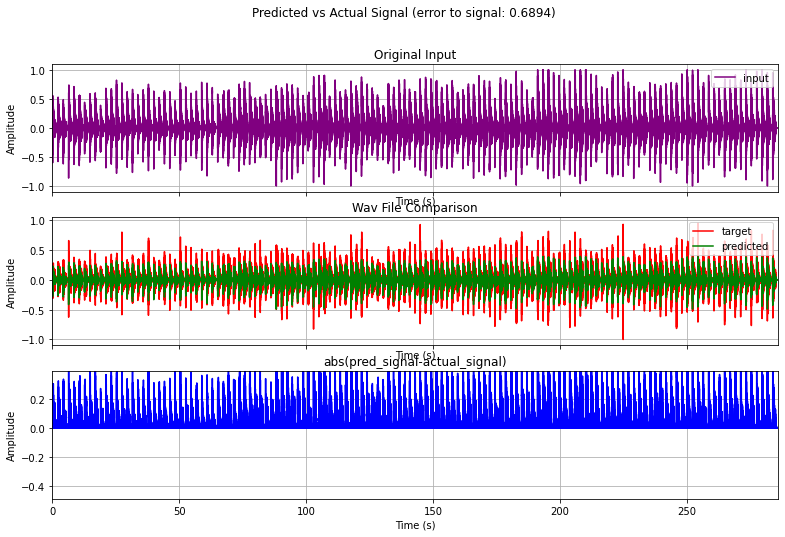

In [ ]:
#plotting the graphs

def error_to_signal(y, y_pred, use_filter=1):
    if use_filter == 1:
        y, y_pred = pre_emphasis_filter(y), pre_emphasis_filter(y_pred)
    return np.sum(np.power(y - y_pred, 2)) / (np.sum(np.power(y, 2) + 1e-10))

def pre_emphasis_filter(x, coeff=0.95):
    return np.concatenate([x, np.subtract(x, np.multiply(x, coeff))])


def read_wave(wav_file):
    # Extract Audio and framerate from Wav File
    fs, signal = wavfile.read(wav_file)
    return signal, fs


def analyze_pred_vs_actual():
    """
    #Generate plots to analyze the predicted signal vs the actual signal.
    1. Plots the two signals
    2. Calculates Error to signal ratio the same way Pedalnet evauluates the model for training
    3. Plots the absolute value of pred_signal - actual_signal  (to visualize abs error over time)
    4. Plots the spectrogram of (pred_signal - actual signal)
         The idea here is to show problem frequencies from the model training
    """
    # Read the input wav file
    signal3, fs3 = read_wave(input_wav)
    #signal3 = signal3 / 32768.0  ################### quick conversion
    # Read the output wav file
    signal1, fs = read_wave(output_wav)
    #signal1 = signal1 / 32768.0   ################### quick conversion
    
    Time = np.linspace(0, len(signal1) / fs, num=len(signal1))
    fig, (ax3, ax1, ax2) = plt.subplots(3, sharex=True, figsize=(13, 8))
    fig.suptitle("Predicted vs Actual Signal")
    ax1.plot(Time, signal1, label='target', color="red")

    # Read the predicted wav file
    signal2, fs2 = read_wave(pred_wav)

    Time2 = np.linspace(0, len(signal2) / fs2, num=len(signal2))
    #doesnt work for best_val_out for chorus-RNN3
    ax1.plot(Time2, signal2, label='predicted', color="green")
    ax1.legend(loc="upper right")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")
    ax1.set_title("Wav File Comparison")
    ax1.grid("on")

    error_list = []
    for s1, s2 in zip(signal1, signal2):
        error_list.append(abs(s2 - s1))

    # Calculate error to signal ratio with pre-emphasis filter as
    #    used to train the model
    e2s = error_to_signal(signal1, signal2)
    e2s_no_filter = error_to_signal(signal1, signal2, use_filter=0)
    print("Error to signal (with pre-emphasis filter): ", e2s)
    print("Error to signal (no pre-emphasis filter): ", e2s_no_filter)
    fig.suptitle("Predicted vs Actual Signal (error to signal: " + str(round(e2s, 4)) + ")")
    
    
    # Plot signal difference
    signal_diff = signal2 - signal1
    ax2.plot(Time2, error_list, label="signal diff", color="blue")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Amplitude")
    ax2.set_title("abs(pred_signal-actual_signal)")
    ax2.grid("on")

    
    # Plot the original signal
    Time3 = np.linspace(0, len(signal3) / fs3, num=len(signal3))
    ax3.plot(Time3, signal3, label='input', color="purple")
    ax3.legend(loc="upper right")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Amplitude")
    ax3.set_title("Original Input")
    ax3.grid("on")
    
    
    """
    # Plot the predicted signal
    Time3 = np.linspace(0, len(signal2) / fs2, num=len(signal2))
    ax3.plot(Time3, signal2, label='predicted', color="purple")
    ax3.legend(loc="upper right")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Amplitude")
    ax3.set_title("Predicted output")
    ax3.grid("on")
    """


    # Save the plot
    plt.savefig(path+'/'+model_name + "_signal_comparison_e2s_" + str(round(e2s, 4)) + ".png", bbox_inches="tight")

    # Create a zoomed in plot of 0.01 seconds centered at the max input signal value
    sig_temp = signal1.tolist()
    plt.axis(
        [
            Time3[sig_temp.index((max(sig_temp)))] - 0.005,
            Time3[sig_temp.index((max(sig_temp)))] + 0.005,
            min(signal2),
            max(signal2),
        ]
    )
    plt.savefig(path+'/'+model_name + "_Detail_signal_comparison_e2s_" + str(round(e2s, 4)) + ".png", bbox_inches="tight")

    # Reset the axis
    plt.axis([0, Time3[-1], min(signal2), max(signal2)])

    if show_plots == 1:
        plt.show()

##Make sure u enter this properly w the right directory
input_wav = "/content/drive/MyDrive/Msc Project/Data/val/chorust-input.wav" #The pre effect signal, by default will use x_test.wav validation set
output_wav = "/content/drive/MyDrive/Msc Project/Data/val/chorust-target.wav" #The actual signal, by default will use y_test.wav validation set

pred_wav = "/content/drive/MyDrive/Msc Project/Results/chorust-RNN1/best_val_out.wav" #The predicted signal, by default will use y_pred.wav from the test.py output
model_name = "RNN1" #Used to add the model name to the plot .png filename
config_name = 'RNN1'  #What config json file did u use?
path = "/content/drive/MyDrive/Msc Project/Results/chorust-RNN1/" #The save path for generated .png figures
show_plots = 1 #Default is 1 to show plots, 0 to only generate

analyze_pred_vs_actual()